# Automated LOINC Standardization Using Pre-trained Large Language Models

## Imports

In [1]:
!pip install nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 7.8 MB/s eta 0:00:0000:01


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text as text
import tensorflow_addons as tfa
from keras import backend as K
from tqdm.notebook import tqdm
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import random

import matplotlib.pyplot as plt
%matplotlib inline

## Data preparation & augmentation

### Load MIMIC-III data
This loads the `D_LABITEMS` tables from MIMC data that's used in the paper

In [3]:
mimc_df = pd.read_csv("/kaggle/input/llm-for-loinc/D_LABITEMS.csv")

# generates source code by concatenating the "label" & "fluid" colummns per the paper
mimc_df["SOURCE_CODE"] = mimc_df.apply(lambda x: (f"{x['LABEL']} {x['FLUID']}").lower(), axis=1)

# drop duplicates
mimc_df = mimc_df[["SOURCE_CODE", "LOINC_CODE"]].dropna().drop_duplicates().drop_duplicates("SOURCE_CODE", keep=False)

# Unique LOINC code in MIMC data
print(f"Unique LOINC codes: {mimc_df['LOINC_CODE'].nunique()}")
print(f"Number of records in MIMC dataset: {len(mimc_df)}")

mimc_df.head()

Unique LOINC codes: 571
Number of records in MIMC dataset: 579


,SOURCE_CODE,LOINC_CODE
0,blasts cerebrospinal fluid (csf),26447-3
1,eosinophils cerebrospinal fluid (csf),26451-5
2,"hematocrit, csf cerebrospinal fluid (csf)",30398-2
3,hypersegmented neutrophils cerebrospinal fluid...,26506-6
5,lymphs cerebrospinal fluid (csf),26479-6


In [4]:
# temp_df = pd.read_csv("/kaggle/input/llm-for-loinc/D_LABITEMS.csv")
# temp_df.head()

### Load official LOINC table (target codes)
This loads the target LOINC codes from the offical table

In [5]:
loinc_df = pd.read_csv("/kaggle/input/llm-for-loinc/Loinc.csv")
loinc_df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (8,16,17,40,42) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,LOINC_NUM,COMPONENT,PROPERTY,TIME_ASPCT,SYSTEM,SCALE_TYP,METHOD_TYP,CLASS,VersionLastChanged,CHNG_TYPE,...,COMMON_ORDER_RANK,COMMON_SI_TEST_RANK,HL7_ATTACHMENT_STRUCTURE,EXTERNAL_COPYRIGHT_LINK,PanelType,AskAtOrderEntry,AssociatedObservations,VersionFirstReleased,ValidHL7AttachmentRequest,DisplayName
0,100002-5,Specimen care is maintained,Find,Pt,^Patient,Ord,NaN,SURVEY.PNDS,2.72,ADD,...,0,0,NaN,NaN,NaN,NaN,NaN,2.72,NaN,NaN
1,100003-3,Team communication is maintained throughout care,Find,Pt,^Patient,Ord,NaN,SURVEY.PNDS,2.72,ADD,...,0,0,NaN,NaN,NaN,NaN,NaN,2.72,NaN,NaN
2,100004-1,Demonstrates knowledge of the expected psychos...,Find,Pt,^Patient,Ord,NaN,SURVEY.PNDS,2.72,ADD,...,0,0,NaN,NaN,NaN,NaN,NaN,2.72,NaN,NaN
3,100005-8,Demonstrates knowledge of nutritional manageme...,Find,Pt,^Patient,Ord,NaN,SURVEY.PNDS,2.72,ADD,...,0,0,NaN,NaN,NaN,NaN,NaN,2.72,NaN,NaN
4,100006-6,Demonstrates knowledge of medication management,Find,Pt,^Patient,Ord,NaN,SURVEY.PNDS,2.72,ADD,...,0,0,NaN,NaN,NaN,NaN,NaN,2.72,NaN,NaN


In [6]:
loinc_df.shape

(98268, 45)

### Data augmentation
Here we define the data augmentation steps following what's described in the paper. Here three augmentation steps are used
- character level random deletion
- Word level random swapping
- Insert random words & acronyms from "RELATEDNAMES2"

In [7]:
aug_random_char_delete = nac.RandomCharAug(
    action = "delete",
    aug_char_min=1,
    aug_char_max=1,
    aug_word_min=1,
    aug_word_max=1,
)

aug_random_word_swap = naw.RandomWordAug(
    action = "swap",
    aug_min=1,
    aug_max=1,
)

def aug_related_word_insert(original, related):
    splitted = original.split(" ")
    words_to_insert = related.split(";")
    
    # pick random words in words_to_insert
    word_to_insert = random.choice(words_to_insert) 
    
    # pick random index to insert the word
    index_to_insert = random.randint(0, len(splitted))
    
    splitted.insert(index_to_insert, word_to_insert)
    transformed = " ".join(splitted)
    return transformed

def augment_steps(row, row_name):
    if type(row[row_name]) is not str:
        return np.nan
    
    if type(row["RELATEDNAMES2"]) is str:
        x = aug_related_word_insert(row[row_name], row["RELATEDNAMES2"])
    else: 
        x = row[row_name]
        
    x = aug_random_char_delete.augment(x)
    x = aug_random_word_swap.augment(x)
    return x[0]

### Prepare data to use pre-trained model
To test the pre-trained model, we need the MIMIC dataset, as well as a subset of the target code table whose LOINC code match that of in the MIMC dataset. No data augmentation is needed here.

In [8]:
# loinc code in the mimic-iii table
mimic_loinc_list = mimc_df["LOINC_CODE"].to_list()
loinc_in_mimic_df = loinc_df[loinc_df["LOINC_NUM"].apply(lambda x: x in mimic_loinc_list)][["LOINC_NUM", "LONG_COMMON_NAME", "DisplayName", "SHORTNAME", "RELATEDNAMES2"]]
loinc_in_mimic_df.head()

,LOINC_NUM,LONG_COMMON_NAME,DisplayName,SHORTNAME,RELATEDNAMES2
524,10330-9,Monocytes/100 leukocytes in Body fluid by Manu...,Monocytes/100 WBC Manual cnt (Body fld),Monocytes/leuk NFr Fld Manual,100WBC; B/F; BF; bod; Bodies; Body fluid; Body...
528,10334-1,Cancer Ag 125 [Units/volume] in Serum or Plasma,Cancer Ag 125 Qn,Cancer Ag125 SerPl-aCnc,Arbitrary concentration; CA; CA 125; Cancer Ag...
540,10346-5,Hemoglobin A [Units/volume] in Blood by Electr...,Hemoglobin A Elph Qn (Bld),Hgb A Bld Elph-aCnc,Arbitrary concentration; Blood; Elec; Elect; E...
551,10355-6,Microscopic observation [Identifier] in Bone m...,Microscopic observation Wright Giemsa stain No...,Wright Gie Stn Mar,BM; BON; Bone marrow; Gie Stn; GMS; ID; Identi...
569,10371-3,Bite cells [Presence] in Blood by Light micros...,Bite cells LM Ql (Bld),Bite cells Bld Ql Smear,Blood; Cell; Cellularity; Degmacytes; HEMATOLO...


### Prepare data for stage one fine-tuning

In [9]:
# Following the paper to extract a subset of LOINC codes in the laboratory and clinical categories
# From LOINC official user guide 1=Laboratory class; 2=Clinical class; 3=Claims attachments; 4=Surveys
loinc_lab_clinical_df = loinc_df[loinc_df["CLASSTYPE"].apply(lambda x: x<=2)][["LOINC_NUM", "LONG_COMMON_NAME", "DisplayName", "SHORTNAME", "RELATEDNAMES2"]].rename(columns={"LOINC_NUM": "LOINC_CODE"})
loinc_lab_clinical_df.shape

(85279, 5)

In [10]:
# encode target as integer (this is needed to use Tripletloss in Tensorflow)
loinc_num_to_index = {k:v for k, v in zip(loinc_lab_clinical_df["LOINC_CODE"].unique(), range(loinc_lab_clinical_df["LOINC_CODE"].nunique()))}
loinc_lab_clinical_df.loc[:, "LOINC_INDEX"] = loinc_lab_clinical_df["LOINC_CODE"].apply(lambda x: loinc_num_to_index[x])
loinc_lab_clinical_df.head()

,LOINC_CODE,LONG_COMMON_NAME,DisplayName,SHORTNAME,RELATEDNAMES2,LOINC_INDEX
6,10000-8,R wave duration in lead AVR,NaN,R wave dur L-AVR,Cardiac; Cardio; Cardiology; Durat; ECG; EKG.M...,0
15,10001-6,R wave duration in lead I,NaN,R wave dur L-I,Cardiac; Cardio; Cardiology; Durat; ECG; EKG.M...,1
18,100018-1,Hospice care Note,NaN,Hospice care Note,Continuity assessment record and evaluation; D...,2
19,100019-9,ALK gene mutations found [Identifier] in Blood...,ALK gene targeted mutation analysis Molgen Nom...,ALK gene Mut Anl Bld/T,ALK receptor tyrosine kinase; Anaplastic lymph...,3
20,100020-7,GNA11 gene mutations found [Identifier] in Blo...,GNA11 gene targeted mutation analysis Molgen N...,GNA11 gene Mut Anl Bld/T,Blood; FBH; FBH2; FHH2; G protein subunit alph...,4


In [11]:
# # apply the data augmentation step (this only needs to be run once as the results will be saved as csv)
# for col in tqdm(["LONG_COMMON_NAME", "DisplayName", "SHORTNAME"]):
#     loinc_lab_clinical_df[f"{col}_AUGMENTED"] = loinc_lab_clinical_df.apply(lambda x: augment_steps(x, col), axis=1)

# loinc_lab_clinical_df.to_csv("Loinc_lab_clinical_augmented.csv")

In [12]:
# Load augmented data
loinc_lab_clinical_df = pd.read_csv("Loinc_lab_clinical_augmented.csv")

In [13]:
# melt the dataframe to long format
loinc_lab_clinical_df_long = loinc_lab_clinical_df.melt(
    id_vars="LOINC_INDEX", 
    value_vars=["LONG_COMMON_NAME_AUGMENTED", "DisplayName_AUGMENTED", "SHORTNAME_AUGMENTED"],
    value_name="LOINC_NAME")
loinc_lab_clinical_df_long = loinc_lab_clinical_df_long[loinc_lab_clinical_df_long["LOINC_NAME"].notna()].sort_values("LOINC_INDEX")
loinc_lab_clinical_df_long.loc[:, "LOINC_NAME"] = loinc_lab_clinical_df_long["LOINC_NAME"].apply(lambda x: x.lower())

loinc_lab_clinical_df_long.head()

,LOINC_INDEX,variable,LOINC_NAME
0,0.0,LONG_COMMON_NAME_AUGMENTED,right r wave dration in lead avr
149772,0.0,SHORTNAME_AUGMENTED,quanttative wave r dur l - avr
149773,1.0,SHORTNAME_AUGMENTED,r wve dur heart disease - l i
1,1.0,LONG_COMMON_NAME_AUGMENTED,r panter s ' colic wave duration in lead i
149774,2.0,SHORTNAME_AUGMENTED,evaluation and management hospice ote care note


### Data preparation for 2nd stage fine-tuning

In [14]:
# encode the target as integer (using same encoding map) for MIMC dataset
mimc_df.loc[:, "LOINC_INDEX"] = mimc_df["LOINC_CODE"].apply(lambda x: loinc_num_to_index[x])
mimc_df.head()

,SOURCE_CODE,LOINC_CODE,LOINC_INDEX
0,blasts cerebrospinal fluid (csf),26447-3,17834
1,eosinophils cerebrospinal fluid (csf),26451-5,17839
2,"hematocrit, csf cerebrospinal fluid (csf)",30398-2,21324
3,hypersegmented neutrophils cerebrospinal fluid...,26506-6,17900
5,lymphs cerebrospinal fluid (csf),26479-6,17869


In [15]:
# Next the "RELATEDNAMES2" column is added to the mimc_df, and then augment it 3 times
mimc_df_with_related_names  = mimc_df.merge(
    loinc_lab_clinical_df[["LOINC_INDEX", "RELATEDNAMES2"]], 
    on="LOINC_INDEX",
    how="left",
)

for i in tqdm(range(1, 1+3)):
    mimc_df_with_related_names[f"SOUCE_CODE_AUGMENTED_{i}"] = mimc_df_with_related_names.apply(lambda x: augment_steps(x, "SOURCE_CODE"), axis=1)

# melt to long format
mimc_df_with_related_names_long = mimc_df_with_related_names.melt(
    id_vars="LOINC_INDEX", 
    value_vars=["SOUCE_CODE_AUGMENTED_1", "SOUCE_CODE_AUGMENTED_2", "SOUCE_CODE_AUGMENTED_3"],
    value_name="LOINC_NAME")
mimc_df_with_related_names_long = mimc_df_with_related_names_long[mimc_df_with_related_names_long["LOINC_NAME"].notna()].sort_values("LOINC_INDEX")
mimc_df_with_related_names_long.loc[:, "LOINC_NAME"] = mimc_df_with_related_names_long["LOINC_NAME"].apply(lambda x: x.lower())

mimc_df_with_related_names_long.head()

  0%|          | 0/3 [00:00<?, ?it/s]

,LOINC_INDEX,variable,LOINC_NAME
65,504,SOUCE_CODE_AUGMENTED_1,oter monos body qnt fluid
1223,504,SOUCE_CODE_AUGMENTED_3,other monos leukocyte body flid
644,504,SOUCE_CODE_AUGMENTED_2,monos body ther fluid percent
1328,508,SOUCE_CODE_AUGMENTED_3,- ca 125 blod carbohydrate antigen 125
749,508,SOUCE_CODE_AUGMENTED_2,serum or ca pasma - 125 blood


In [16]:
# For 2nd stage fine-tuning we only need the part of loinc_lab_clinical_df_long whose LOINC code appears in MIMC
mimic_loinc_index = mimc_df.loc[:, "LOINC_INDEX"].to_list()
loinc_lab_clinical_df_long_2nd_stage = loinc_lab_clinical_df_long[loinc_lab_clinical_df_long["LOINC_INDEX"].apply(lambda x: x in mimic_loinc_index)]
loinc_lab_clinical_df_long_2nd_stage = loinc_lab_clinical_df_long_2nd_stage.astype({"LOINC_INDEX": "int64"})
loinc_lab_clinical_df_long_2nd_stage

,LOINC_INDEX,variable,LOINC_NAME
75390,504,DisplayName_AUGMENTED,monocytes / b 100 / f wbc anual cnt (body fld )
504,504,LONG_COMMON_NAME_AUGMENTED,monocytes / 100 leukocytes in white blood ody ...
150276,504,SHORTNAME_AUGMENTED,rndom monocytes / leuk nfr manual fld
508,508,LONG_COMMON_NAME_AUGMENTED,cancer ca ag 125 units [/ volume] in serum or ...
75394,508,DisplayName_AUGMENTED,cancer point in tie 125 ag qn
...,...,...,...
145588,70702,DisplayName_AUGMENTED,mucus lm ql (urne sed urns )
70702,70702,LONG_COMMON_NAME_AUGMENTED,mucus micro [presene] in urine sediment light ...
70711,70711,LONG_COMMON_NAME_AUGMENTED,spermatozoa micro [presence] in urine by sedim...
220483,70711,SHORTNAME_AUGMENTED,urns serm ua ql micro


In [17]:
# Combine source and target dataset (post augmentation) to make the trainning/eval data for 2nd stage fine-tuning
source_target_2nd_stage_df = pd.concat(
    [loinc_lab_clinical_df_long_2nd_stage, mimc_df_with_related_names_long],
    axis=0
).sort_values("LOINC_INDEX")

source_target_2nd_stage_df.head(10)

,LOINC_INDEX,variable,LOINC_NAME
75390,504,DisplayName_AUGMENTED,monocytes / b 100 / f wbc anual cnt (body fld )
644,504,SOUCE_CODE_AUGMENTED_2,monos body ther fluid percent
1223,504,SOUCE_CODE_AUGMENTED_3,other monos leukocyte body flid
65,504,SOUCE_CODE_AUGMENTED_1,oter monos body qnt fluid
150276,504,SHORTNAME_AUGMENTED,rndom monocytes / leuk nfr manual fld
504,504,LONG_COMMON_NAME_AUGMENTED,monocytes / 100 leukocytes in white blood ody ...
75394,508,DisplayName_AUGMENTED,cancer point in tie 125 ag qn
508,508,LONG_COMMON_NAME_AUGMENTED,cancer ca ag 125 units [/ volume] in serum or ...
170,508,SOUCE_CODE_AUGMENTED_1,universallaborders ca - bloo 125
749,508,SOUCE_CODE_AUGMENTED_2,serum or ca pasma - 125 blood


## Performance using pre-trained LLM
In this step the pre-trained T5 model is loaded and used to extract embeddings from the source & target codes. The embedding is later used for calculating cosine similarity which is used for top-k accuracy calculation.

In [22]:
hub_url = "https://tfhub.dev/google/sentence-t5/st5-base/1"
encoder = hub.KerasLayer(hub_url)

In [23]:
# Embeddings of LOINC code - LONG_COMMON_NAME using official LOINC table
loinc_sentences = tf.constant(loinc_in_mimic_df["LONG_COMMON_NAME"].apply(lambda x: x.lower()).to_list())
loinc_embeds = encoder(loinc_sentences)

# Embeddings of source code based in MIMC data
mimc_sentences = tf.constant(mimc_df["SOURCE_CODE"].to_list())
mimc_embeds = encoder(mimc_sentences)

# calculating cosine similarity for each potential source-target pair; note that tensor multiplication is used here instead of for loop for performance
y_pred = tf.matmul(mimc_embeds[0], loinc_embeds[0], transpose_b=True)

# Encode ground truth labels with one-hot
y_true = np.zeros((len(mimc_sentences), len(loinc_sentences)))
loinc_num_to_index = {k: v for k, v in zip(loinc_in_mimic_df["LOINC_NUM"].to_list(), range(len(loinc_in_mimic_df)))}
for i in range(len(mimc_sentences)):
    code_true = mimc_df.iloc[i]["LOINC_CODE"]
    index = loinc_num_to_index[code_true]
    y_true[i][index] = 1 

# calculate top K accuracy
for k in (1, 3, 5):
    m = tf.keras.metrics.TopKCategoricalAccuracy(
        k=k, name='top_k_categorical_accuracy', dtype=None
    )
    m.update_state(y_true, y_pred)
    print(f"top {k} accuracy {m.result().numpy()}")

top 1 accuracy 0.48704662919044495
top 3 accuracy 0.7167530059814453
top 5 accuracy 0.8048359155654907


## First-stage fine-tuning using target codes only
In this stage the fine-tuning is done on the FC-connected layer (T5 backbone weights is not changed). Note that the fine-tune step is using augmented target codes only from the offical LOINC table.

### Set up model

In [18]:
# To speed up training 2x T4 GPUs (offered by Kaggle) is used; mirror strategy is used
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

DEVICES AVAILABLE: 2


In [19]:
# This defines the architecture of the model
def build_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
    hub_url = "https://tfhub.dev/google/sentence-t5/st5-base/1"
    encoder = hub.KerasLayer(hub_url, load_options=load_locally, trainable=False, name='ST5_base_encoder')
    
    output = encoder(text_input)[0]
    output = tf.keras.layers.Dropout(rate=0, seed=0)(output)
    output = tf.keras.layers.Dense(128, activation=None)(output)
    output = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(output) # L2 normalize embeddings
    return tf.keras.Model(text_input, output)

In [20]:
with strategy.scope():
    first_stage_model = build_model()
    
    # use adam optimizer and learning rate of 1e-4 as specified in the paper
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,)
    
    # here we focus on TripletSemiHardLoss only (original paper studied both semihard & hard triplet search strategies)
    loss = tfa.losses.TripletSemiHardLoss(margin=0.8)

    first_stage_model.compile(
        optimizer=optimizer,
        loss=loss,
    )

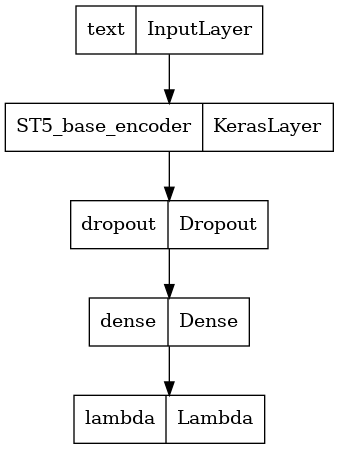

In [21]:
tf.keras.utils.plot_model(first_stage_model)

In [22]:
first_stage_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None,)]                 0         
                                                                 
 ST5_base_encoder (KerasLaye  [(None, 768)]            0         
 r)                                                              
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 lambda (Lambda)             (None, 128)               0         
                                                                 
Total params: 98,432
Trainable params: 98,432
Non-trainable params: 0
_________________________________________________________

### Train/validation split

In [67]:
train_df, val_df = train_test_split(
    loinc_lab_clinical_df_long, test_size=0.2, random_state=0, shuffle=False)

train_dataset = tf.data.Dataset.from_tensor_slices((train_df["LOINC_NAME"], train_df["LOINC_INDEX"]))
train_dataset = train_dataset.batch(600)

val_dataset = tf.data.Dataset.from_tensor_slices((val_df["LOINC_NAME"], val_df["LOINC_INDEX"]))
val_dataset = val_dataset.batch(600)

### Train model

In [42]:
epochs = 20

# set up checkpoints
checkpoint_filepath = '/checkpoints/model_{epoch:02d}-{val_loss:.2f}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    save_freq="epoch"
)

# Train the network
history = first_stage_model.fit(
    train_dataset,
    validation_data=val_dataset,
    callbacks=[model_checkpoint_callback],
    epochs=epochs,
)

Epoch 1/20
307/307 [==============================] - 1759s 6s/step - loss: 0.7274 - val_loss: 0.7080
Epoch 2/20
307/307 [==============================] - 1721s 6s/step - loss: 0.6973 - val_loss: 0.6951
Epoch 3/20
307/307 [==============================] - 1707s 6s/step - loss: 0.6845 - val_loss: 0.6876
Epoch 4/20
307/307 [==============================] - 1708s 6s/step - loss: 0.6762 - val_loss: 0.6826
Epoch 5/20
307/307 [==============================] - 1709s 6s/step - loss: 0.6702 - val_loss: 0.6790
Epoch 6/20
307/307 [==============================] - 1712s 6s/step - loss: 0.6656 - val_loss: 0.6764
Epoch 7/20
307/307 [==============================] - 1710s 6s/step - loss: 0.6618 - val_loss: 0.6741
Epoch 8/20
307/307 [==============================] - 1717s 6s/step - loss: 0.6587 - val_loss: 0.6724
Epoch 9/20
307/307 [==============================] - 1712s 6s/step - loss: 0.6561 - val_loss: 0.6707
Epoch 10/20
307/307 [==============================] - 1710s 6s/step - loss: 0.653

dict_keys(['loss', 'val_loss'])


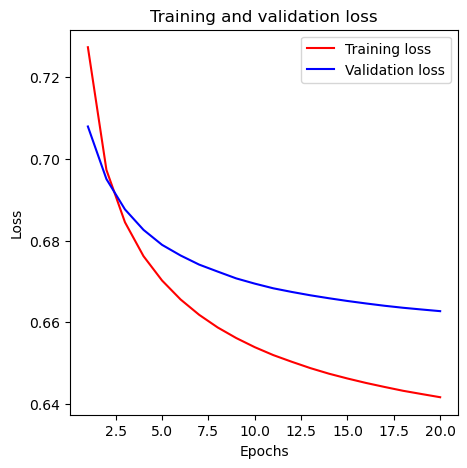

In [43]:
# plot training curve

history_dict = history.history
print(history_dict.keys())

loss = history_dict['loss']
val_loss = history_dict['val_loss']

# acc = history_dict['acc']
# val_acc = history_dict['val_acc']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(5, 5))
fig.tight_layout()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig("training_plot.png")

In [44]:
# save model
# first_stage_model.save("first_stage_model_epoch_1")
first_stage_model.save("first_stage_model_epoch_20")

In [52]:
# save model
# first_stage_model.save("first_stage_model_epoch_1")
first_stage_model_loaded.save("first_stage_model_epoch_20_backup")

In [47]:
first_stage_model_loaded = tf.keras.models.load_model('first_stage_model_epoch_20')

In [48]:
# Load trained model 
first_stage_model = tf.keras.models.load_model('first_stage_model_epoch_20')

In [64]:
!zip -r first_stage_model_epoch_20.zip first_stage_model_epoch_20/

  adding: first_stage_model_epoch_20/ (stored 0%)
  adding: first_stage_model_epoch_20/variables/ (stored 0%)
  adding: first_stage_model_epoch_20/variables/variables.index (deflated 79%)
  adding: first_stage_model_epoch_20/variables/variables.data-00000-of-00001 (deflated 53%)
  adding: first_stage_model_epoch_20/assets/ (stored 0%)
  adding: first_stage_model_epoch_20/keras_metadata.pb (deflated 82%)
  adding: first_stage_model_epoch_20/saved_model.pb (deflated 76%)
  adding: first_stage_model_epoch_20/fingerprint.pb (stored 0%)


In [68]:
!zip -r first_stage_model_epoch_20_backup.zip first_stage_model_epoch_20_backup/

  adding: first_stage_model_epoch_20_backup/ (stored 0%)
  adding: first_stage_model_epoch_20_backup/variables/ (stored 0%)
  adding: first_stage_model_epoch_20_backup/variables/variables.index (deflated 80%)
  adding: first_stage_model_epoch_20_backup/variables/variables.data-00000-of-00001 (deflated 53%)
  adding: first_stage_model_epoch_20_backup/assets/ (stored 0%)
  adding: first_stage_model_epoch_20_backup/keras_metadata.pb (deflated 82%)
  adding: first_stage_model_epoch_20_backup/saved_model.pb (deflated 76%)
  adding: first_stage_model_epoch_20_backup/fingerprint.pb (stored 0%)


In [69]:
# Embeddings of LOINC code - LONG_COMMON_NAME using official LOINC table
loinc_sentences = tf.constant(loinc_in_mimic_df["LONG_COMMON_NAME"].apply(lambda x: x.lower()).to_list())
loinc_embeds = first_stage_model(loinc_sentences)

# Embeddings of source code based in MIMC data
mimc_sentences = tf.constant(mimc_df["SOURCE_CODE"].to_list())
mimc_embeds = first_stage_model(mimc_sentences)

# calculating cosine similarity for each potential source-target pair; note that tensor multiplication is used here instead of for loop for performance
y_pred = tf.matmul(mimc_embeds, loinc_embeds, transpose_b=True)

# Encode ground truth labels with one-hot
y_true = np.zeros((len(mimc_sentences), len(loinc_sentences)))
loinc_num_to_index = {k: v for k, v in zip(loinc_in_mimic_df["LOINC_NUM"].to_list(), range(len(loinc_in_mimic_df)))}
for i in range(len(mimc_sentences)):
    code_true = mimc_df.iloc[i]["LOINC_CODE"]
    index = loinc_num_to_index[code_true]
    y_true[i][index] = 1 

# calculate top K accuracy
for k in (1, 3, 5):
    m = tf.keras.metrics.TopKCategoricalAccuracy(
        k=k, name='top_k_categorical_accuracy', dtype=None
    )
    m.update_state(y_true, y_pred)
    print(f"top {k} accuracy {m.result().numpy()}")

top 1 accuracy 0.6390328407287598
top 3 accuracy 0.8013817071914673
top 5 accuracy 0.8549222946166992


## Second-stage fine-tuning using source-target pair
In this stage further fine-tuning is done on the FC-connected layer with source codes and targets codes.

Epoch 1/20
4/4 [==============================] - 83s 16s/step - loss: 0.7753 - val_loss: 0.6823
Epoch 2/20
4/4 [==============================] - 18s 5s/step - loss: 0.7747 - val_loss: 0.6821
Epoch 3/20
4/4 [==============================] - 19s 5s/step - loss: 0.7739 - val_loss: 0.6819
Epoch 4/20
4/4 [==============================] - 20s 5s/step - loss: 0.7729 - val_loss: 0.6817
Epoch 5/20
4/4 [==============================] - 20s 5s/step - loss: 0.7740 - val_loss: 0.6815
Epoch 6/20
4/4 [==============================] - 20s 5s/step - loss: 0.7739 - val_loss: 0.6814
Epoch 7/20
4/4 [==============================] - 20s 5s/step - loss: 0.7751 - val_loss: 0.6811
Epoch 8/20
4/4 [==============================] - 20s 5s/step - loss: 0.7733 - val_loss: 0.6812
Epoch 9/20
4/4 [==============================] - 21s 6s/step - loss: 0.7746 - val_loss: 0.6812
Epoch 10/20
4/4 [==============================] - 20s 5s/step - loss: 0.7727 - val_loss: 0.6810
Epoch 11/20
4/4 [=====================

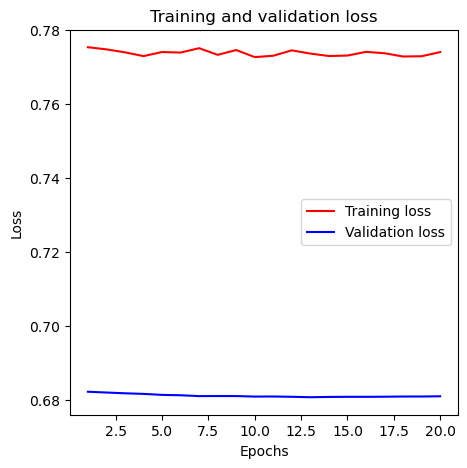

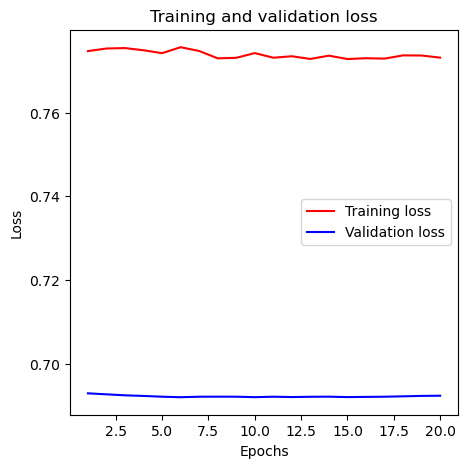

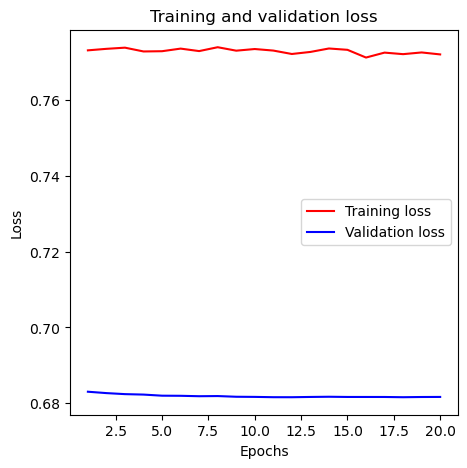

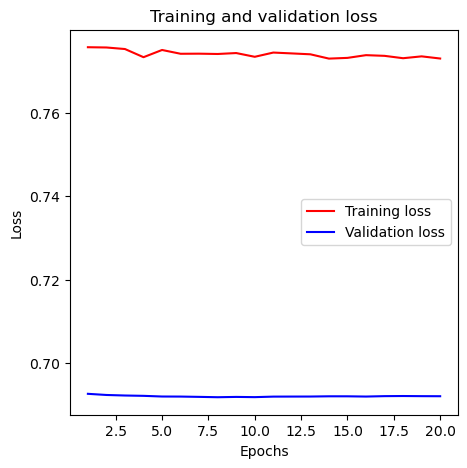

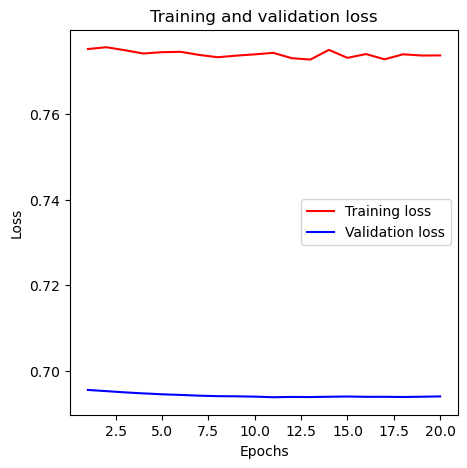

In [18]:
# Kfold results
accu = {
    1: [],
    3: [],
    5: [],
}

# accu_augmented = {
#     1: [],
#     3: [],
#     5: [],
# }

kf = KFold(n_splits=5, random_state=0, shuffle=True)

for fold, (train_index, test_index) in enumerate(kf.split(mimic_loinc_index)):
    
    with strategy.scope():
        # load model trained from first-stage
        first_stage_model_saved = tf.keras.models.load_model('first_stage_model_epoch_20')
        
        # add none-zero dropout rate
        first_stage_model_saved.layers[2].rate = 0.2
        
        # reduced reduced learning rate of 1e-5
        K.set_value(first_stage_model_saved.optimizer.learning_rate, 1e-5)
        
    # train/val/test split
    mimic_loinc_index_train = [mimic_loinc_index[i] for i in train_index]
    mimic_loinc_index_test = [mimic_loinc_index[i] for i in test_index]
    mimic_loinc_index_train, mimic_loinc_index_val = train_test_split(
        mimic_loinc_index_train, test_size=0.2, random_state=0, shuffle=False
    )
    
    train_df = source_target_2nd_stage_df[source_target_2nd_stage_df["LOINC_INDEX"].apply(lambda x: x in mimic_loinc_index_train)]
    train_dataset = tf.data.Dataset.from_tensor_slices((train_df["LOINC_NAME"], train_df["LOINC_INDEX"]))
    train_dataset = train_dataset.batch(600)
    
    val_df = source_target_2nd_stage_df[source_target_2nd_stage_df["LOINC_INDEX"].apply(lambda x: x in mimic_loinc_index_val)]
    val_dataset = tf.data.Dataset.from_tensor_slices((val_df["LOINC_NAME"], val_df["LOINC_INDEX"]))
    val_dataset = val_dataset.batch(600)
    
    history_2nd_stage = first_stage_model_saved.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=20,
    )
    
    first_stage_model_saved.save(f"second_stage_model_fold_{fold}")
    
    # plot learning curve
    history_dict = history_2nd_stage.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"training_plot_2nd_stage_kfold_{fold}.png")
    
    # test data without augmentation
    test_df = mimc_df.iloc[test_index]
#     test_dataset = tf.data.Dataset.from_tensor_slices((test_df["SOURCE_CODE"], test_df["LOINC_INDEX"]))
#     test_dataset = val_dataset.batch(600)
    
    # Embeddings of target after first stage training
    loinc_sentences = tf.constant(loinc_in_mimic_df["LONG_COMMON_NAME"].apply(lambda x: x.lower()).to_list())
    mimc_sentences = tf.constant(test_df["SOURCE_CODE"].to_list())

    loinc_embeds = first_stage_model_saved(loinc_sentences)
    mimc_embeds = first_stage_model_saved(mimc_sentences)
    
    # Encode ground truth labels with one-hot
    y_true = np.zeros((len(mimc_sentences), len(loinc_sentences)))
    loinc_num_to_index = {k: v for k, v in zip(loinc_in_mimic_df["LOINC_NUM"].to_list(), range(len(loinc_in_mimic_df)))}
    for i in range(len(mimc_sentences)):
        code_true = test_df.iloc[i]["LOINC_CODE"]
        index = loinc_num_to_index[code_true]
        y_true[i][index] = 1
    
    # calculate cosine similarity 
    y_pred_second_stage = tf.matmul(mimc_embeds, loinc_embeds, transpose_b=True)
    
    # calculate top K accuracy
    for k in (1, 3, 5):
        m = tf.keras.metrics.TopKCategoricalAccuracy(
            k=k, name='top_k_categorical_accuracy', dtype=None
        )
        m.update_state(y_true, y_pred_second_stage)
        accu[k].append(m.result().numpy())
        print(f"Fold {fold}, top {k} accuracy {m.result().numpy()}")
        
    ######   test data with augmentation  #######
    
    # work in progress
    
#     test_df_with_related_names = test_df.merge(mimc_df_with_related_names[["LOINC_CODE", "RELATEDNAMES2"]], on="LOINC_CODE", how="left")
#     test_df_augmented = []

#     for i in range(100):
#         df_to_add = test_df_with_related_names.apply(lambda x: augment_steps(x, "SOURCE_CODE"), axis=1).to_frame("SOURCE_CODE")
#         df_to_add["LOINC_INDEX"] = test_df_with_related_names["LOINC_INDEX"]
#         df_to_add["LOINC_CODE"] = test_df_with_related_names["LOINC_CODE"]
#         test_df_augmented.append(df_to_add)

#     test_df_augmented = pd.concat(test_df_augmented, axis=0).drop_duplicates()

# #     test_dataset = tf.data.Dataset.from_tensor_slices(test_df_augmented["SOURCE_CODE"])
#     # test_dataset = val_dataset.batch(800)

#     # Embeddings of target after first stage training
#     loinc_sentences = tf.constant(loinc_in_mimic_df["LONG_COMMON_NAME"].apply(lambda x: x.lower()).to_list())
#     mimc_sentences = tf.constant(test_df_augmented["SOURCE_CODE"].to_list())

#     loinc_embeds = first_stage_model_saved(loinc_sentences)
#     mimc_embeds = first_stage_model_saved.predict(
#         mimc_sentences,
#         batch_size=600,
#     )

#     # calculate cosine similarity of every source-code / long-common-name pair

#     y_pred_second_stage = tf.matmul(mimc_embeds, loinc_embeds, transpose_b=True)

#     # Encode ground truth labels with one-hot
#     y_true = np.zeros((len(mimc_sentences), len(loinc_sentences)))

#     loinc_num_to_index = {k: v for k, v in zip(loinc_in_mimic_df["LOINC_NUM"].to_list(), range(len(loinc_in_mimic_df)))}

#     for i in range(len(mimc_sentences)):
#         code_true = test_df_augmented.iloc[i]["LOINC_CODE"]
#         index = loinc_num_to_index[code_true]
#         y_true[i][index] = 1

#     # calculate top K accuracy
#     for k in (1, 3, 5):
#         m = tf.keras.metrics.TopKCategoricalAccuracy(
#             k=k, name='top_k_categorical_accuracy', dtype=None
#         )
#         m.update_state(y_true, y_pred_second_stage)
#         accu_augmented[k].append(m.result().numpy())
#         print(f"Fold {fold}, top {k} accuracy {m.result().numpy()}")

In [22]:
accu_df = pd.DataFrame(accu)

accu_df_summary = pd.DataFrame(
{
    "mean": accu_df.apply(np.mean, axis=0),
    "std": accu_df.apply(np.std, axis=0)
})

accu_df_summary.to_csv("2nd_stage_result_without_augmentation_semihard.csv")

accu_df_summary

,mean,std
1,0.663253,0.027854
3,0.815247,0.017308
5,0.868756,0.012504


In [18]:
# Test without augmentation

# Kfold results
accu = {
    1: [],
    3: [],
    5: [],
}

# accu_augmented = {
#     1: [],
#     3: [],
#     5: [],
# }

kf = KFold(n_splits=5, random_state=0, shuffle=True)


for fold, (train_index, test_index) in enumerate(kf.split(mimic_loinc_index)):

    # load model trained from 2nd-stage
    second_stage_model_saved = tf.keras.models.load_model(f"second_stage_model_fold_{fold}")
        
        
    # train/val/test split
    mimic_loinc_index_test = [mimic_loinc_index[i] for i in test_index]
    
    # test data without augmentation
    test_df = mimc_df.iloc[test_index]
#     test_dataset = tf.data.Dataset.from_tensor_slices((test_df["SOURCE_CODE"], test_df["LOINC_INDEX"]))
#     test_dataset = val_dataset.batch(600)
    
    # Embeddings of target after first stage training
    loinc_sentences = tf.constant(loinc_in_mimic_df["LONG_COMMON_NAME"].apply(lambda x: x.lower()).to_list())
    mimc_sentences = tf.constant(test_df["SOURCE_CODE"].to_list())

    loinc_embeds = second_stage_model_saved(loinc_sentences)
    mimc_embeds = second_stage_model_saved(mimc_sentences)
    
    # Encode ground truth labels with one-hot
    y_true = np.zeros((len(mimc_sentences), len(loinc_sentences)))
    loinc_num_to_index = {k: v for k, v in zip(loinc_in_mimic_df["LOINC_NUM"].to_list(), range(len(loinc_in_mimic_df)))}
    for i in range(len(mimc_sentences)):
        code_true = test_df.iloc[i]["LOINC_CODE"]
        index = loinc_num_to_index[code_true]
        y_true[i][index] = 1
    
    # calculate cosine similarity 
    y_pred_second_stage = tf.matmul(mimc_embeds, loinc_embeds, transpose_b=True)
    
    # calculate top K accuracy
    for k in (1, 3, 5):
        m = tf.keras.metrics.TopKCategoricalAccuracy(
            k=k, name='top_k_categorical_accuracy', dtype=None
        )
        m.update_state(y_true, y_pred_second_stage)
        accu[k].append(m.result().numpy())
        print(f"Fold {fold}, top {k} accuracy {m.result().numpy()}")
        
    ######   test data with augmentation  #######
    
    # work in progress
    
#     test_df_with_related_names = test_df.merge(mimc_df_with_related_names[["LOINC_CODE", "RELATEDNAMES2"]], on="LOINC_CODE", how="left")
#     test_df_augmented = []

#     for i in range(100):
#         df_to_add = test_df_with_related_names.apply(lambda x: augment_steps(x, "SOURCE_CODE"), axis=1).to_frame("SOURCE_CODE")
#         df_to_add["LOINC_INDEX"] = test_df_with_related_names["LOINC_INDEX"]
#         df_to_add["LOINC_CODE"] = test_df_with_related_names["LOINC_CODE"]
#         test_df_augmented.append(df_to_add)

#     test_df_augmented = pd.concat(test_df_augmented, axis=0).drop_duplicates()

# #     test_dataset = tf.data.Dataset.from_tensor_slices(test_df_augmented["SOURCE_CODE"])
#     # test_dataset = val_dataset.batch(800)

#     # Embeddings of target after first stage training
#     loinc_sentences = tf.constant(loinc_in_mimic_df["LONG_COMMON_NAME"].apply(lambda x: x.lower()).to_list())
#     mimc_sentences = tf.constant(test_df_augmented["SOURCE_CODE"].to_list())

#     loinc_embeds = first_stage_model_saved(loinc_sentences)
#     mimc_embeds = first_stage_model_saved.predict(
#         mimc_sentences,
#         batch_size=600,
#     )

#     # calculate cosine similarity of every source-code / long-common-name pair

#     y_pred_second_stage = tf.matmul(mimc_embeds, loinc_embeds, transpose_b=True)

#     # Encode ground truth labels with one-hot
#     y_true = np.zeros((len(mimc_sentences), len(loinc_sentences)))

#     loinc_num_to_index = {k: v for k, v in zip(loinc_in_mimic_df["LOINC_NUM"].to_list(), range(len(loinc_in_mimic_df)))}

#     for i in range(len(mimc_sentences)):
#         code_true = test_df_augmented.iloc[i]["LOINC_CODE"]
#         index = loinc_num_to_index[code_true]
#         y_true[i][index] = 1

#     # calculate top K accuracy
#     for k in (1, 3, 5):
#         m = tf.keras.metrics.TopKCategoricalAccuracy(
#             k=k, name='top_k_categorical_accuracy', dtype=None
#         )
#         m.update_state(y_true, y_pred_second_stage)
#         accu_augmented[k].append(m.result().numpy())
#         print(f"Fold {fold}, top {k} accuracy {m.result().numpy()}")

Fold 0, top 1 accuracy 0.6637930870056152
Fold 0, top 3 accuracy 0.818965494632721
Fold 0, top 5 accuracy 0.8534482717514038
Fold 1, top 1 accuracy 0.6206896305084229
Fold 1, top 3 accuracy 0.7931034564971924
Fold 1, top 5 accuracy 0.8620689511299133
Fold 2, top 1 accuracy 0.6982758641242981
Fold 2, top 3 accuracy 0.818965494632721
Fold 2, top 5 accuracy 0.8879310488700867
Fold 3, top 1 accuracy 0.6465517282485962
Fold 3, top 3 accuracy 0.8017241358757019
Fold 3, top 5 accuracy 0.8620689511299133
Fold 4, top 1 accuracy 0.686956524848938
Fold 4, top 3 accuracy 0.843478262424469
Fold 4, top 5 accuracy 0.8782608509063721


In [21]:
# Test with augmentation

# Kfold results

accu_augmented = {
    1: [],
    3: [],
    5: [],
}

kf = KFold(n_splits=5, random_state=0, shuffle=True)

for fold, (train_index, test_index) in enumerate(kf.split(mimic_loinc_index)):

    # load model trained from 2nd-stage
    second_stage_model_saved = tf.keras.models.load_model(f"second_stage_model_fold_{fold}")
          
    # train/val/test split
    mimic_loinc_index_test = [mimic_loinc_index[i] for i in test_index]
    
#     # test data without augmentation
#     test_df = mimc_df.iloc[test_index]
# #     test_dataset = tf.data.Dataset.from_tensor_slices((test_df["SOURCE_CODE"], test_df["LOINC_INDEX"]))
# #     test_dataset = val_dataset.batch(600)
    
#     # Embeddings of target after first stage training
#     loinc_sentences = tf.constant(loinc_in_mimic_df["LONG_COMMON_NAME"].apply(lambda x: x.lower()).to_list())
#     mimc_sentences = tf.constant(test_df["SOURCE_CODE"].to_list())

#     loinc_embeds = first_stage_model_saved(loinc_sentences)
#     mimc_embeds = first_stage_model_saved(mimc_sentences)
    
#     # Encode ground truth labels with one-hot
#     y_true = np.zeros((len(mimc_sentences), len(loinc_sentences)))
#     loinc_num_to_index = {k: v for k, v in zip(loinc_in_mimic_df["LOINC_NUM"].to_list(), range(len(loinc_in_mimic_df)))}
#     for i in range(len(mimc_sentences)):
#         code_true = test_df.iloc[i]["LOINC_CODE"]
#         index = loinc_num_to_index[code_true]
#         y_true[i][index] = 1
    
#     # calculate cosine similarity 
#     y_pred_second_stage = tf.matmul(mimc_embeds, loinc_embeds, transpose_b=True)
    
#     # calculate top K accuracy
#     for k in (1, 3, 5):
#         m = tf.keras.metrics.TopKCategoricalAccuracy(
#             k=k, name='top_k_categorical_accuracy', dtype=None
#         )
#         m.update_state(y_true, y_pred_second_stage)
#         accu[k].append(m.result().numpy())
#         print(f"Fold {fold}, top {k} accuracy {m.result().numpy()}")
        
    ######   test data with augmentation  #######
    
    test_df_with_related_names = test_df.merge(mimc_df_with_related_names[["LOINC_CODE", "RELATEDNAMES2"]], on="LOINC_CODE", how="left")
    test_df_augmented = []

    for i in range(100):
        df_to_add = test_df_with_related_names.apply(lambda x: augment_steps(x, "SOURCE_CODE"), axis=1).to_frame("SOURCE_CODE")
        df_to_add["LOINC_INDEX"] = test_df_with_related_names["LOINC_INDEX"]
        df_to_add["LOINC_CODE"] = test_df_with_related_names["LOINC_CODE"]
        test_df_augmented.append(df_to_add)

    test_df_augmented = pd.concat(test_df_augmented, axis=0).drop_duplicates()

#     test_dataset = tf.data.Dataset.from_tensor_slices(test_df_augmented["SOURCE_CODE"])
    # test_dataset = val_dataset.batch(800)

    # Embeddings of target after first stage training
    loinc_sentences = tf.constant(loinc_in_mimic_df["LONG_COMMON_NAME"].apply(lambda x: x.lower()).to_list())
    mimc_sentences = tf.constant(test_df_augmented["SOURCE_CODE"].to_list())

    loinc_embeds = second_stage_model_saved(loinc_sentences)
    mimc_embeds = second_stage_model_saved.predict(
        mimc_sentences,
        batch_size=600,
    )

    # calculate cosine similarity of every source-code / long-common-name pair

    y_pred_second_stage = tf.matmul(mimc_embeds, loinc_embeds, transpose_b=True)

    # Encode ground truth labels with one-hot
    y_true = np.zeros((len(mimc_sentences), len(loinc_sentences)))

    loinc_num_to_index = {k: v for k, v in zip(loinc_in_mimic_df["LOINC_NUM"].to_list(), range(len(loinc_in_mimic_df)))}

    for i in range(len(mimc_sentences)):
        code_true = test_df_augmented.iloc[i]["LOINC_CODE"]
        index = loinc_num_to_index[code_true]
        y_true[i][index] = 1

    # calculate top K accuracy
    for k in (1, 3, 5):
        m = tf.keras.metrics.TopKCategoricalAccuracy(
            k=k, name='top_k_categorical_accuracy', dtype=None
        )
        m.update_state(y_true, y_pred_second_stage)
        accu_augmented[k].append(m.result().numpy())
        print(f"Fold {fold}, top {k} accuracy {m.result().numpy()}")

20/20 [==============================] - 175s 8s/step
Fold 0, top 1 accuracy 0.612054169178009
Fold 0, top 3 accuracy 0.778377890586853
Fold 0, top 5 accuracy 0.8243312835693359
20/20 [==============================] - 165s 8s/step
Fold 1, top 1 accuracy 0.606913685798645
Fold 1, top 3 accuracy 0.7803542613983154
Fold 1, top 5 accuracy 0.8318644762039185
20/20 [==============================] - 166s 8s/step
Fold 2, top 1 accuracy 0.6054118871688843
Fold 2, top 3 accuracy 0.7732488512992859
Fold 2, top 5 accuracy 0.8237711787223816
20/20 [==============================] - 165s 8s/step
Fold 3, top 1 accuracy 0.611553966999054
Fold 3, top 3 accuracy 0.7800634503364563
Fold 3, top 5 accuracy 0.8293477296829224
20/20 [==============================] - 166s 8s/step
Fold 4, top 1 accuracy 0.6104775667190552
Fold 4, top 3 accuracy 0.7758724093437195
Fold 4, top 5 accuracy 0.8252593874931335


In [23]:
accu_df = pd.DataFrame(accu_augmented)

accu_df_summary = pd.DataFrame(
{
    "mean": accu_df.apply(np.mean, axis=0),
    "std": accu_df.apply(np.std, axis=0)
})

accu_df_summary.to_csv("2nd_stage_result_with_augmentation_semihard.csv")

accu_df_summary

,mean,std
1,0.609282,0.002641
3,0.777583,0.002690
5,0.826915,0.003153


## Skip first stage fine-tuning

Epoch 1/20
4/4 [==============================] - 79s 16s/step - loss: 0.7933 - val_loss: 0.7785
Epoch 2/20
4/4 [==============================] - 19s 5s/step - loss: 0.7928 - val_loss: 0.7774
Epoch 3/20
4/4 [==============================] - 20s 5s/step - loss: 0.7926 - val_loss: 0.7762
Epoch 4/20
4/4 [==============================] - 20s 5s/step - loss: 0.7919 - val_loss: 0.7750
Epoch 5/20
4/4 [==============================] - 20s 5s/step - loss: 0.7917 - val_loss: 0.7735
Epoch 6/20
4/4 [==============================] - 20s 5s/step - loss: 0.7908 - val_loss: 0.7719
Epoch 7/20
4/4 [==============================] - 20s 5s/step - loss: 0.7899 - val_loss: 0.7700
Epoch 8/20
4/4 [==============================] - 20s 5s/step - loss: 0.7893 - val_loss: 0.7681
Epoch 9/20
4/4 [==============================] - 20s 5s/step - loss: 0.7886 - val_loss: 0.7663
Epoch 10/20
4/4 [==============================] - 20s 5s/step - loss: 0.7883 - val_loss: 0.7641
Epoch 11/20
4/4 [=====================

,mean,std
1,0.637361,0.036867
3,0.785907,0.028108
5,0.842924,0.031205


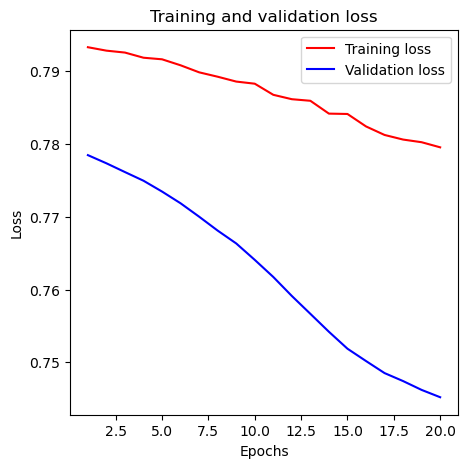

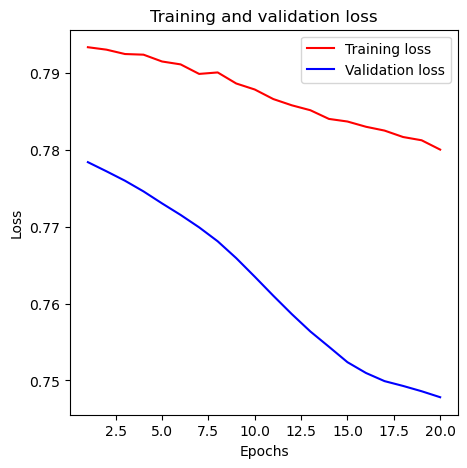

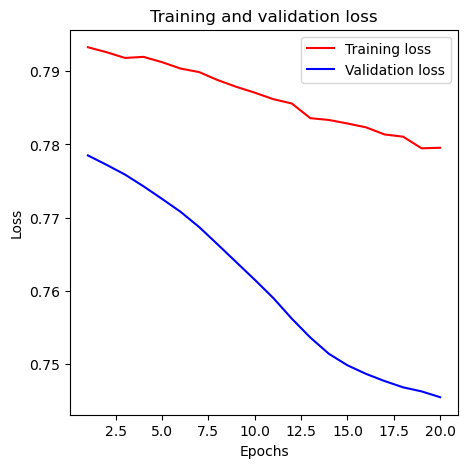

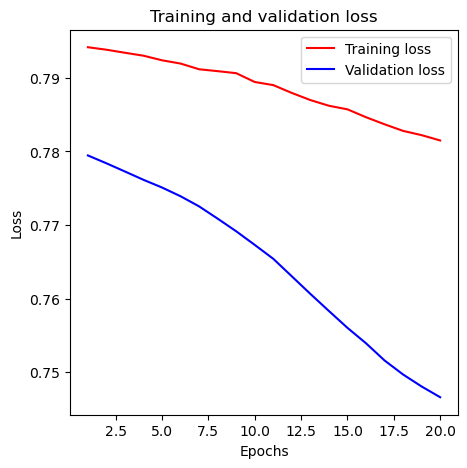

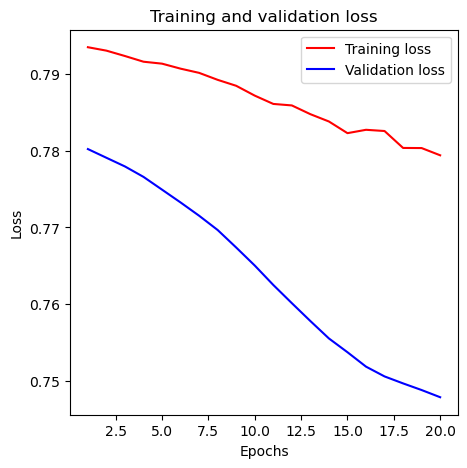

In [23]:
# Kfold results
accu = {
    1: [],
    3: [],
    5: [],
}

kf = KFold(n_splits=5, random_state=0, shuffle=True)

for fold, (train_index, test_index) in enumerate(kf.split(mimic_loinc_index)):
    
    with strategy.scope():
        # load model trained from first-stage
        first_stage_model_saved = build_model()
        
        # use adam optimizer and learning rate of 1e-4 as specified in the paper
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,)

        # here we focus on TripletSemiHardLoss only (original paper studied both semihard & hard triplet search strategies)
        loss = tfa.losses.TripletSemiHardLoss(margin=0.8)

        first_stage_model_saved.compile(
            optimizer=optimizer,
            loss=loss,
        )
        
#         add none-zero dropout rate
        first_stage_model_saved.layers[2].rate = 0.2
        
        # reduced reduced learning rate of 1e-5
#         K.set_value(first_stage_model_saved.optimizer.learning_rate, 1e-5)
        
    # train/val/test split
    mimic_loinc_index_train = [mimic_loinc_index[i] for i in train_index]
    mimic_loinc_index_test = [mimic_loinc_index[i] for i in test_index]
    mimic_loinc_index_train, mimic_loinc_index_val = train_test_split(
        mimic_loinc_index_train, test_size=0.2, random_state=0, shuffle=False
    )
    
    train_df = source_target_2nd_stage_df[source_target_2nd_stage_df["LOINC_INDEX"].apply(lambda x: x in mimic_loinc_index_train)]
    train_dataset = tf.data.Dataset.from_tensor_slices((train_df["LOINC_NAME"], train_df["LOINC_INDEX"]))
    train_dataset = train_dataset.batch(600)
    
    val_df = source_target_2nd_stage_df[source_target_2nd_stage_df["LOINC_INDEX"].apply(lambda x: x in mimic_loinc_index_val)]
    val_dataset = tf.data.Dataset.from_tensor_slices((val_df["LOINC_NAME"], val_df["LOINC_INDEX"]))
    val_dataset = val_dataset.batch(600)
    
    history_2nd_stage = first_stage_model_saved.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=20,
    )
    
    first_stage_model_saved.save(f"second_stage_model_skip_first_stage_fold_{fold}")
    
    # plot learning curve
    history_dict = history_2nd_stage.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"training_plot_2nd_stage_slip_1st_stage_kfold_{fold}.png")
    
    # test data without augmentation
    test_df = mimc_df.iloc[test_index]
#     test_dataset = tf.data.Dataset.from_tensor_slices((test_df["SOURCE_CODE"], test_df["LOINC_INDEX"]))
#     test_dataset = val_dataset.batch(600)
    
    # Embeddings of target after first stage training
    loinc_sentences = tf.constant(loinc_in_mimic_df["LONG_COMMON_NAME"].apply(lambda x: x.lower()).to_list())
    mimc_sentences = tf.constant(test_df["SOURCE_CODE"].to_list())

    loinc_embeds = first_stage_model_saved(loinc_sentences)
    mimc_embeds = first_stage_model_saved(mimc_sentences)
    
    # Encode ground truth labels with one-hot
    y_true = np.zeros((len(mimc_sentences), len(loinc_sentences)))
    loinc_num_to_index = {k: v for k, v in zip(loinc_in_mimic_df["LOINC_NUM"].to_list(), range(len(loinc_in_mimic_df)))}
    for i in range(len(mimc_sentences)):
        code_true = test_df.iloc[i]["LOINC_CODE"]
        index = loinc_num_to_index[code_true]
        y_true[i][index] = 1
    
    # calculate cosine similarity 
    y_pred_second_stage = tf.matmul(mimc_embeds, loinc_embeds, transpose_b=True)
    
    # calculate top K accuracy
    for k in (1, 3, 5):
        m = tf.keras.metrics.TopKCategoricalAccuracy(
            k=k, name='top_k_categorical_accuracy', dtype=None
        )
        m.update_state(y_true, y_pred_second_stage)
        accu[k].append(m.result().numpy())
        print(f"Fold {fold}, top {k} accuracy {m.result().numpy()}")
        
accu_df = pd.DataFrame(accu)

accu_df_summary = pd.DataFrame(
{
    "mean": accu_df.apply(np.mean, axis=0),
    "std": accu_df.apply(np.std, axis=0)
})

accu_df_summary.to_csv("2nd_stage_result_skip_1st_stage_without_augmentation_semihard.csv")

accu_df_summary
        

In [24]:
# Test with augmentation

# Kfold results

accu_augmented = {
    1: [],
    3: [],
    5: [],
}

kf = KFold(n_splits=5, random_state=0, shuffle=True)

for fold, (train_index, test_index) in enumerate(kf.split(mimic_loinc_index)):

    # load model trained from 2nd-stage
    second_stage_model_saved = tf.keras.models.load_model(f"second_stage_model_skip_first_stage_fold_{fold}")
          
    # train/val/test split
    mimic_loinc_index_test = [mimic_loinc_index[i] for i in test_index]
    
#     # test data without augmentation
#     test_df = mimc_df.iloc[test_index]
# #     test_dataset = tf.data.Dataset.from_tensor_slices((test_df["SOURCE_CODE"], test_df["LOINC_INDEX"]))
# #     test_dataset = val_dataset.batch(600)
    
#     # Embeddings of target after first stage training
#     loinc_sentences = tf.constant(loinc_in_mimic_df["LONG_COMMON_NAME"].apply(lambda x: x.lower()).to_list())
#     mimc_sentences = tf.constant(test_df["SOURCE_CODE"].to_list())

#     loinc_embeds = first_stage_model_saved(loinc_sentences)
#     mimc_embeds = first_stage_model_saved(mimc_sentences)
    
#     # Encode ground truth labels with one-hot
#     y_true = np.zeros((len(mimc_sentences), len(loinc_sentences)))
#     loinc_num_to_index = {k: v for k, v in zip(loinc_in_mimic_df["LOINC_NUM"].to_list(), range(len(loinc_in_mimic_df)))}
#     for i in range(len(mimc_sentences)):
#         code_true = test_df.iloc[i]["LOINC_CODE"]
#         index = loinc_num_to_index[code_true]
#         y_true[i][index] = 1
    
#     # calculate cosine similarity 
#     y_pred_second_stage = tf.matmul(mimc_embeds, loinc_embeds, transpose_b=True)
    
#     # calculate top K accuracy
#     for k in (1, 3, 5):
#         m = tf.keras.metrics.TopKCategoricalAccuracy(
#             k=k, name='top_k_categorical_accuracy', dtype=None
#         )
#         m.update_state(y_true, y_pred_second_stage)
#         accu[k].append(m.result().numpy())
#         print(f"Fold {fold}, top {k} accuracy {m.result().numpy()}")
        
    ######   test data with augmentation  #######
    
    test_df_with_related_names = test_df.merge(mimc_df_with_related_names[["LOINC_CODE", "RELATEDNAMES2"]], on="LOINC_CODE", how="left")
    test_df_augmented = []

    for i in range(100):
        df_to_add = test_df_with_related_names.apply(lambda x: augment_steps(x, "SOURCE_CODE"), axis=1).to_frame("SOURCE_CODE")
        df_to_add["LOINC_INDEX"] = test_df_with_related_names["LOINC_INDEX"]
        df_to_add["LOINC_CODE"] = test_df_with_related_names["LOINC_CODE"]
        test_df_augmented.append(df_to_add)

    test_df_augmented = pd.concat(test_df_augmented, axis=0).drop_duplicates()

#     test_dataset = tf.data.Dataset.from_tensor_slices(test_df_augmented["SOURCE_CODE"])
    # test_dataset = val_dataset.batch(800)

    # Embeddings of target after first stage training
    loinc_sentences = tf.constant(loinc_in_mimic_df["LONG_COMMON_NAME"].apply(lambda x: x.lower()).to_list())
    mimc_sentences = tf.constant(test_df_augmented["SOURCE_CODE"].to_list())

    loinc_embeds = second_stage_model_saved(loinc_sentences)
    mimc_embeds = second_stage_model_saved.predict(
        mimc_sentences,
        batch_size=600,
    )

    # calculate cosine similarity of every source-code / long-common-name pair

    y_pred_second_stage = tf.matmul(mimc_embeds, loinc_embeds, transpose_b=True)

    # Encode ground truth labels with one-hot
    y_true = np.zeros((len(mimc_sentences), len(loinc_sentences)))

    loinc_num_to_index = {k: v for k, v in zip(loinc_in_mimic_df["LOINC_NUM"].to_list(), range(len(loinc_in_mimic_df)))}

    for i in range(len(mimc_sentences)):
        code_true = test_df_augmented.iloc[i]["LOINC_CODE"]
        index = loinc_num_to_index[code_true]
        y_true[i][index] = 1

    # calculate top K accuracy
    for k in (1, 3, 5):
        m = tf.keras.metrics.TopKCategoricalAccuracy(
            k=k, name='top_k_categorical_accuracy', dtype=None
        )
        m.update_state(y_true, y_pred_second_stage)
        accu_augmented[k].append(m.result().numpy())
        print(f"Fold {fold}, top {k} accuracy {m.result().numpy()}")
        
        
accu_df = pd.DataFrame(accu_augmented)

accu_df_summary = pd.DataFrame(
{
    "mean": accu_df.apply(np.mean, axis=0),
    "std": accu_df.apply(np.std, axis=0)
})

accu_df_summary.to_csv("2nd_stage_result_skip_1st_with_augmentation_semihard.csv")

accu_df_summary

20/20 [==============================] - 178s 8s/step
Fold 0, top 1 accuracy 0.579950213432312
Fold 0, top 3 accuracy 0.7628529667854309
Fold 0, top 5 accuracy 0.825251042842865
20/20 [==============================] - 166s 8s/step
Fold 1, top 1 accuracy 0.5783556699752808
Fold 1, top 3 accuracy 0.7415894269943237
Fold 1, top 5 accuracy 0.799519419670105
20/20 [==============================] - 166s 8s/step
Fold 2, top 1 accuracy 0.5666896104812622
Fold 2, top 3 accuracy 0.73504638671875
Fold 2, top 5 accuracy 0.8038845062255859
20/20 [==============================] - 166s 8s/step
Fold 3, top 1 accuracy 0.58809894323349
Fold 3, top 3 accuracy 0.7697921991348267
Fold 3, top 5 accuracy 0.8317018747329712
20/20 [==============================] - 168s 8s/step
Fold 4, top 1 accuracy 0.561370313167572
Fold 4, top 3 accuracy 0.7398003339767456
Fold 4, top 5 accuracy 0.8103804588317871


,mean,std
1,0.574893,0.009614
3,0.749816,0.013821
5,0.814147,0.012369
